## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Sat Apr 06 19:25:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 399.24                 Driver Version: 399.24                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970    WDDM  | 00000000:01:00.0  On |                  N/A |
| 34%   32C    P8    18W / 250W |    290MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import keras
import tensorflow as tf

from numba import cuda
cuda.select_device(0)
cuda.close()

import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=y_train.shape[-1], n_layers=4, num_neurons=[512, 256, 128, 64]):

    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons[:n_layers]):
        if i == 0:
            x = keras.layers.BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units,activation='relu',
                                   name='hidden_layers'+str(i+1))(x)
        else:
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units,activation='relu',
                                   name='hidden_layers'+str(i+1))(x)

    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [9]:
## 超參數設定

LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 2048
OPTIMIZER = ['Adam','RMSprop']
FACTOR = [ 0.3, 0.4, 0.5]
PATIENCE = [5, 10, 15]

In [10]:
def model_fitting( factor, patience, learning_rate=LEARNING_RATE, optimizer=OPTIMIZER, 
                  epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=x_train.shape[1:] ):

    keras.backend.clear_session()
    ########################################
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    ########################################
    
    model = build_mlp( input_shape=input_shape )
    model.summary()

    selector = {'SGD': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'RMSprop': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'AdaGrad': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'Adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}

    optimizer = selector.get(optimizer)

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    # 載入 Callbacks
     ## model_ckpt =  keras.callbacks.ModelCheckpoint(filepath='./tmp.h5', monitor='val_loss',save_best_only = save_best_only )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=factor,
                                                  min_lr=1e-12,
                                                  monitor='val_loss',
                                                  mode='min',
                                                  patience=patience,
                                                  verbose=1)
    
   
    
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=(x_test, y_test), 
                        shuffle=False, 
                        callbacks=[reduce_lr],
                        verbose=1)
    
    ##################
    sess.close()
    ##################
    
    return history

In [11]:
results = {}

for factor, patience, optimizer in itertools.product(FACTOR, PATIENCE, OPTIMIZER):
    
    outcome = model_fitting( factor=factor, patience=patience, optimizer=optimizer )
    
    ########## Load back
    # temp_model = keras.models.load_model("./tmp.h5")
    # loss_loadback, acc_loadback = temp_model.evaluate(x_test, y_test)
    #########
    
    name_tag = f'Factor:{factor}, Patience:{patience}, Optimizer:{optimizer}'
    results[name_tag] = {'train-loss': outcome.history['loss'],
                         'valid-loss': outcome.history['val_loss'],
                         'train-acc': outcome.history['acc'],
                         'valid-acc': outcome.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128)               32896     
__________

Epoch 44/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.2024 - acc: 0.9614 - val_loss: 1.7173 - val_acc: 0.5271
Epoch 45/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.2024 - acc: 0.9614 - val_loss: 1.7174 - val_acc: 0.5272
Epoch 46/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.2024 - acc: 0.9614 - val_loss: 1.7175 - val_acc: 0.5272

Epoch 00046: ReduceLROnPlateau reducing learning rate to 6.561000276406048e-08.
Epoch 47/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2023 - acc: 0.9614 - val_loss: 1.7176 - val_acc: 0.5272
Epoch 48/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2023 - acc: 0.9614 - val_loss: 1.7176 - val_acc: 0.5271
Epoch 49/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.2023 - acc: 0.9614 - val_loss: 1.7177 - val_acc: 0.5271
Epoch 50/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.2023 - ac

50000/50000 [==============================] - 3s 56us/step - loss: 0.1495 - acc: 0.9747 - val_loss: 1.8169 - val_acc: 0.5277
Epoch 38/50
50000/50000 [==============================] - 3s 55us/step - loss: 0.1491 - acc: 0.9749 - val_loss: 1.8186 - val_acc: 0.5275
Epoch 39/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.1487 - acc: 0.9751 - val_loss: 1.8201 - val_acc: 0.5275
Epoch 40/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.1484 - acc: 0.9751 - val_loss: 1.8215 - val_acc: 0.5274

Epoch 00040: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
Epoch 41/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.1478 - acc: 0.9753 - val_loss: 1.8223 - val_acc: 0.5276
Epoch 42/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.1477 - acc: 0.9753 - val_loss: 1.8230 - val_acc: 0.5278
Epoch 43/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.1476 - acc: 0.9754 - 

50000/50000 [==============================] - 3s 52us/step - loss: 0.0738 - acc: 0.9922 - val_loss: 2.0202 - val_acc: 0.5285
Epoch 32/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.0697 - acc: 0.9933 - val_loss: 2.0359 - val_acc: 0.5284
Epoch 33/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.0661 - acc: 0.9941 - val_loss: 2.0503 - val_acc: 0.5283
Epoch 34/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.0629 - acc: 0.9944 - val_loss: 2.0645 - val_acc: 0.5288
Epoch 35/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.0600 - acc: 0.9949 - val_loss: 2.0783 - val_acc: 0.5298
Epoch 36/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.0573 - acc: 0.9954 - val_loss: 2.0916 - val_acc: 0.5294

Epoch 00036: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 37/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.0538 - acc: 0.9958 - 

50000/50000 [==============================] - 3s 50us/step - loss: 0.1364 - acc: 0.9723 - val_loss: 1.8789 - val_acc: 0.5266
Epoch 27/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.1193 - acc: 0.9777 - val_loss: 1.9408 - val_acc: 0.5260
Epoch 28/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.1093 - acc: 0.9794 - val_loss: 1.9906 - val_acc: 0.5285
Epoch 29/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.0914 - acc: 0.9842 - val_loss: 2.0501 - val_acc: 0.5272
Epoch 30/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.0870 - acc: 0.9844 - val_loss: 2.1184 - val_acc: 0.5241

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 31/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.0628 - acc: 0.9919 - val_loss: 2.1351 - val_acc: 0.5284
Epoch 32/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.0532 - acc: 0.9940 - 

50000/50000 [==============================] - 3s 51us/step - loss: 0.2956 - acc: 0.9039 - val_loss: 1.8354 - val_acc: 0.5297
Epoch 22/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.1956 - acc: 0.9481 - val_loss: 1.8422 - val_acc: 0.5294
Epoch 23/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.1545 - acc: 0.9654 - val_loss: 1.8753 - val_acc: 0.5314
Epoch 24/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.1289 - acc: 0.9752 - val_loss: 1.9197 - val_acc: 0.5327
Epoch 25/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.1107 - acc: 0.9806 - val_loss: 1.9638 - val_acc: 0.5332
Epoch 26/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.0965 - acc: 0.9851 - val_loss: 2.0094 - val_acc: 0.5304
Epoch 27/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.0860 - acc: 0.9879 - val_loss: 2.0530 - val_acc: 0.5296
Epoch 28/50
50000/50000 [=====================

Epoch 17/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.5801 - acc: 0.8057 - val_loss: 1.5837 - val_acc: 0.5190
Epoch 18/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.5561 - acc: 0.8161 - val_loss: 1.6210 - val_acc: 0.5141
Epoch 19/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.5112 - acc: 0.8306 - val_loss: 1.6859 - val_acc: 0.5111
Epoch 20/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.4717 - acc: 0.8433 - val_loss: 1.6567 - val_acc: 0.5245
Epoch 21/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.4429 - acc: 0.8543 - val_loss: 1.7058 - val_acc: 0.5259
Epoch 22/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.4146 - acc: 0.8636 - val_loss: 1.7529 - val_acc: 0.5215
Epoch 23/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.3802 - acc: 0.8764 - val_loss: 1.8128 - val_acc: 0.5208
Epoch 24/50
50000/50000 [=========

50000/50000 [==============================] - 3s 52us/step - loss: 0.5576 - acc: 0.8197 - val_loss: 1.5021 - val_acc: 0.5253
Epoch 13/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.4917 - acc: 0.8486 - val_loss: 1.5325 - val_acc: 0.5227
Epoch 14/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.4370 - acc: 0.8716 - val_loss: 1.5663 - val_acc: 0.5229
Epoch 15/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3944 - acc: 0.8875 - val_loss: 1.6211 - val_acc: 0.5194

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
Epoch 16/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.3509 - acc: 0.8995 - val_loss: 1.6092 - val_acc: 0.5241
Epoch 17/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.3175 - acc: 0.9145 - val_loss: 1.6272 - val_acc: 0.5256
Epoch 18/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2876 - acc: 0.9279 -

50000/50000 [==============================] - 3s 55us/step - loss: 1.3139 - acc: 0.5375 - val_loss: 1.5415 - val_acc: 0.4656
Epoch 5/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.2272 - acc: 0.5714 - val_loss: 1.5389 - val_acc: 0.4690
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.1552 - acc: 0.5971 - val_loss: 1.4836 - val_acc: 0.4870
Epoch 7/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.0912 - acc: 0.6219 - val_loss: 1.3995 - val_acc: 0.5131
Epoch 8/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.0285 - acc: 0.6443 - val_loss: 1.4559 - val_acc: 0.4967
Epoch 9/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.9731 - acc: 0.6657 - val_loss: 1.4565 - val_acc: 0.5095
Epoch 10/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.9189 - acc: 0.6826 - val_loss: 1.5457 - val_acc: 0.4887
Epoch 11/50
50000/50000 [==========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.8659 - acc: 0.3558 - val_loss: 1.6441 - val_acc: 0.4298
Epoch 2/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.5059 - acc: 0.4691 - val_loss: 1.4816 - val_acc: 0.4784
Epoch 3/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.3563 - acc: 0.5240 - val_loss: 1.4165 - val_acc: 0.4972
Epoch 4/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2434 - acc: 0.5648 - val_loss: 1.3791 - val_acc: 0.5080
Epoch 5/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.1425 - acc: 0.6007 - val_loss: 1.3709 - val_acc: 0.5174
Epoch 6/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.0525 - acc: 0.6330 - val_loss: 1.3808 - val_acc: 0.5121
Epoch 7/50
50000/50000 [==============================] - 3s 55us/step - loss: 0.9681 - acc: 0.6642 - val_loss: 1.4089 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.8547 - acc: 0.3574 - val_loss: 1.7306 - val_acc: 0.3985
Epoch 2/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.5308 - acc: 0.4609 - val_loss: 1.6925 - val_acc: 0.4231
Epoch 3/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.4172 - acc: 0.4994 - val_loss: 1.5423 - val_acc: 0.4562
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.3123 - acc: 0.5398 - val_loss: 1.5551 - val_acc: 0.4636
Epoch 5/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.2452 - acc: 0.5625 - val_loss: 1.4864 - val_acc: 0.4678
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.1685 - acc: 0.5911 - val_loss: 1.4795 - val_acc: 0.4841
Epoch 7/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.1015 - acc: 0.6153 - val_loss: 1.5121 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.8221 - acc: 0.3624 - val_loss: 1.6341 - val_acc: 0.4326
Epoch 2/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.4925 - acc: 0.4726 - val_loss: 1.4748 - val_acc: 0.4777
Epoch 3/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.3459 - acc: 0.5249 - val_loss: 1.4094 - val_acc: 0.5017
Epoch 4/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2269 - acc: 0.5691 - val_loss: 1.3886 - val_acc: 0.5042
Epoch 5/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.1205 - acc: 0.6101 - val_loss: 1.3831 - val_acc: 0.5111
Epoch 6/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.0259 - acc: 0.6432 - val_loss: 1.3951 - val_acc: 0.5074
Epoch 7/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.9485 - acc: 0.6734 - val_loss: 1.4205 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.8432 - acc: 0.3544 - val_loss: 1.7027 - val_acc: 0.3964
Epoch 2/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.5306 - acc: 0.4603 - val_loss: 1.6482 - val_acc: 0.4233
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.4143 - acc: 0.5033 - val_loss: 1.5644 - val_acc: 0.4569
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.3146 - acc: 0.5390 - val_loss: 1.5288 - val_acc: 0.4702
Epoch 5/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.2460 - acc: 0.5635 - val_loss: 1.4782 - val_acc: 0.4774
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.1700 - acc: 0.5922 - val_loss: 1.5117 - val_acc: 0.4762
Epoch 7/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.0983 - acc: 0.6194 - val_loss: 1.4552 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.8710 - acc: 0.3501 - val_loss: 1.6523 - val_acc: 0.4200
Epoch 2/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.5133 - acc: 0.4688 - val_loss: 1.4983 - val_acc: 0.4726
Epoch 3/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.3685 - acc: 0.5178 - val_loss: 1.4367 - val_acc: 0.4902
Epoch 4/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.2484 - acc: 0.5626 - val_loss: 1.3972 - val_acc: 0.5031
Epoch 5/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.1500 - acc: 0.6001 - val_loss: 1.3965 - val_acc: 0.5012
Epoch 6/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.0584 - acc: 0.6304 - val_loss: 1.3889 - val_acc: 0.5085
Epoch 7/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.9717 - acc: 0.6639 - val_loss: 1.4021 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.8785 - acc: 0.3522 - val_loss: 1.7087 - val_acc: 0.4032
Epoch 2/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.5535 - acc: 0.4507 - val_loss: 1.8056 - val_acc: 0.4177
Epoch 3/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.4285 - acc: 0.4970 - val_loss: 1.5337 - val_acc: 0.4590
Epoch 4/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.3319 - acc: 0.5333 - val_loss: 1.5751 - val_acc: 0.4627
Epoch 5/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.2526 - acc: 0.5600 - val_loss: 1.4370 - val_acc: 0.5007
Epoch 6/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.1820 - acc: 0.5871 - val_loss: 1.4905 - val_acc: 0.4840
Epoch 7/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.1148 - acc: 0.6105 - val_loss: 1.5259 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.8426 - acc: 0.3550 - val_loss: 1.6441 - val_acc: 0.4271
Epoch 2/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.4903 - acc: 0.4750 - val_loss: 1.4802 - val_acc: 0.4766
Epoch 3/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.3382 - acc: 0.5311 - val_loss: 1.4158 - val_acc: 0.4999
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.2164 - acc: 0.5741 - val_loss: 1.3941 - val_acc: 0.5017
Epoch 5/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.1143 - acc: 0.6098 - val_loss: 1.3853 - val_acc: 0.5105
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.0220 - acc: 0.6444 - val_loss: 1.3862 - val_acc: 0.5133
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.9483 - acc: 0.6693 - val_loss: 1.4088 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.9187 - acc: 0.3439 - val_loss: 1.7321 - val_acc: 0.3999
Epoch 2/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.5606 - acc: 0.4515 - val_loss: 1.6363 - val_acc: 0.4319
Epoch 3/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.4362 - acc: 0.4922 - val_loss: 1.6165 - val_acc: 0.4564
Epoch 4/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.3331 - acc: 0.5303 - val_loss: 1.5375 - val_acc: 0.4620
Epoch 5/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.2518 - acc: 0.5625 - val_loss: 1.4636 - val_acc: 0.4778
Epoch 6/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.1769 - acc: 0.5888 - val_loss: 1.4622 - val_acc: 0.4923
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.1160 - acc: 0.6106 - val_loss: 1.4897 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.8642 - acc: 0.3582 - val_loss: 1.6785 - val_acc: 0.4201
Epoch 2/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.5083 - acc: 0.4683 - val_loss: 1.5063 - val_acc: 0.4678
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.3539 - acc: 0.5223 - val_loss: 1.4341 - val_acc: 0.4944
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.2333 - acc: 0.5651 - val_loss: 1.3954 - val_acc: 0.5045
Epoch 5/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.1262 - acc: 0.6066 - val_loss: 1.3929 - val_acc: 0.5104
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.0390 - acc: 0.6382 - val_loss: 1.3863 - val_acc: 0.5122
Epoch 7/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.9646 - acc: 0.6638 - val_loss: 1.4010 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.8345 - acc: 0.3600 - val_loss: 1.6631 - val_acc: 0.4143
Epoch 2/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.5317 - acc: 0.4569 - val_loss: 1.6855 - val_acc: 0.4275
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.4090 - acc: 0.5022 - val_loss: 1.5554 - val_acc: 0.4558
Epoch 4/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.3174 - acc: 0.5343 - val_loss: 1.5701 - val_acc: 0.4602
Epoch 5/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.2458 - acc: 0.5610 - val_loss: 1.4994 - val_acc: 0.4681
Epoch 6/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.1694 - acc: 0.5894 - val_loss: 1.5909 - val_acc: 0.4505
Epoch 7/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.1093 - acc: 0.6128 - val_loss: 1.5391 - val_acc

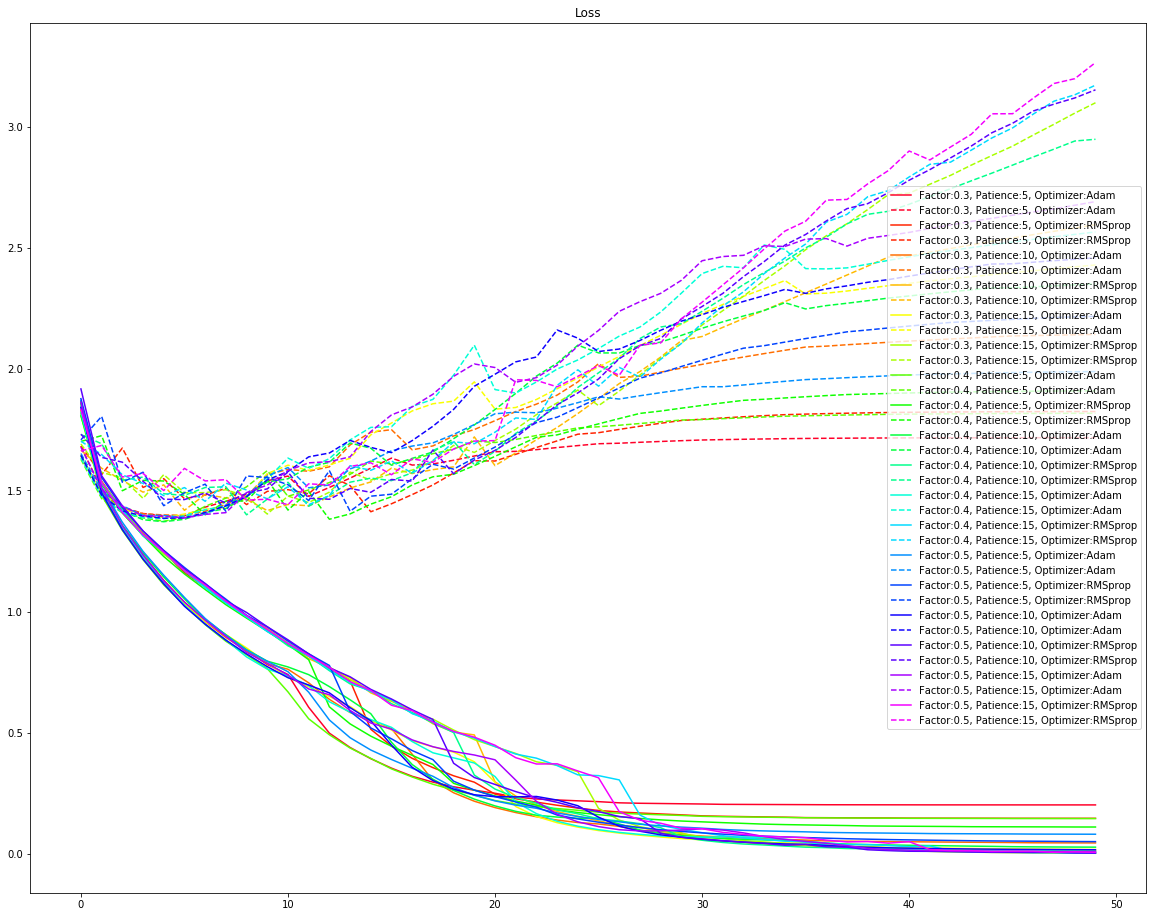

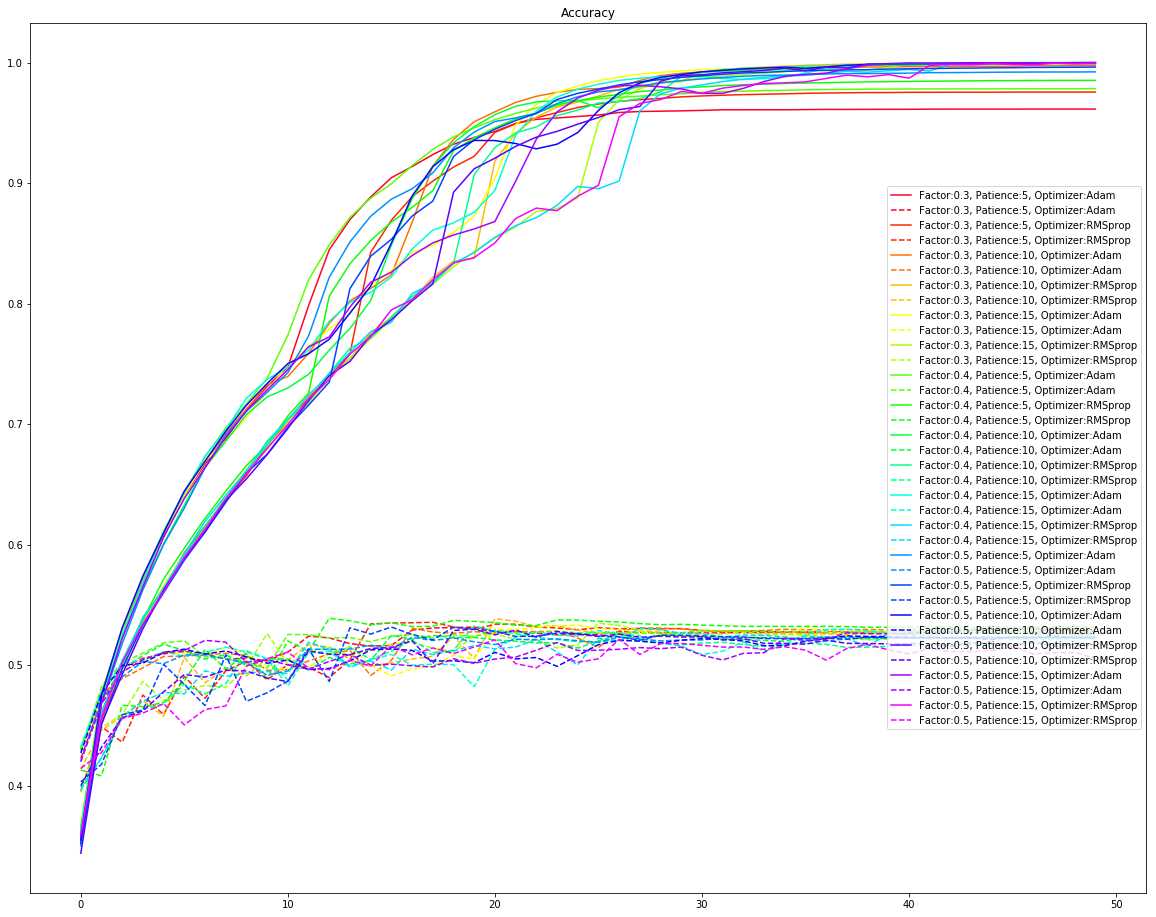

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

#############################################################
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
#############################################################

plt.figure(figsize=(20, 16))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(20, 16))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='right')
plt.show()